In [16]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score

In [17]:
import os
import numpy as np
import requests

# Download the required files.

def download_file(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful.
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")


In [18]:
class LandscapesDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform
        self.label = self.data_frame['type']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = f"{self.data_frame.iloc[idx, 0]}.jpg"
        try:
            image = Image.open(image_path).convert('RGB')  
        except (IOError, SyntaxError) as e:
            print(f"Error opening image at {image_path}, skipping to next.")
            return self.__getitem__((idx + 1) % len(self))  
        
        if self.transform:
            image = self.transform(image)
            
        label = int(self.data_frame.iloc[idx, 1])
        return image, torch.tensor(label, dtype=torch.long)

In [26]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

# th architecture to use
arch = 'resnet50'
save_dir = '../../models'
# load the pre-trained weights
model_file = os.path.join(save_dir, '%s_places365.pth.tar' % arch)
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + os.path.basename(model_file)
    os.system(f'wget -O {model_file} {weight_url}') 

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()


/tmp/ipykernel_545817/554744740.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Processing images:   0%|                                 | 0/10 [00:00<?, ?it/s]

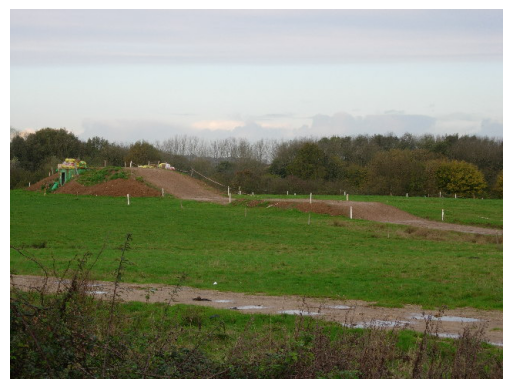

Processing images:  10%|██▌                      | 1/10 [00:01<00:09,  1.03s/it]

resnet50 prediction on photos/07/70/077072_64ab6e94.jpg
0.160 -> wind_farm
0.135 -> desert/vegetation
0.102 -> tree_farm
0.067 -> field_road
0.066 -> pasture


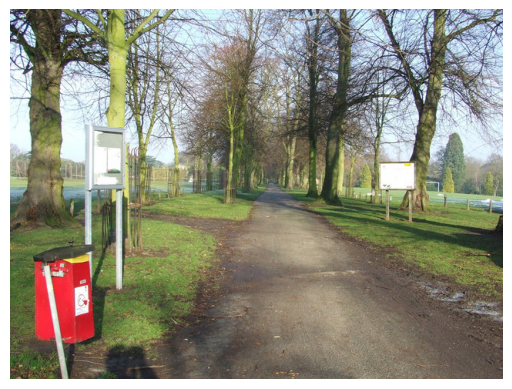

Processing images:  20%|█████                    | 2/10 [00:01<00:06,  1.26it/s]

resnet50 prediction on geophotos/01/14/76/1147682_c23a6f3d.jpg
0.474 -> forest_path
0.115 -> park
0.077 -> driveway
0.037 -> field/wild
0.033 -> forest/broadleaf


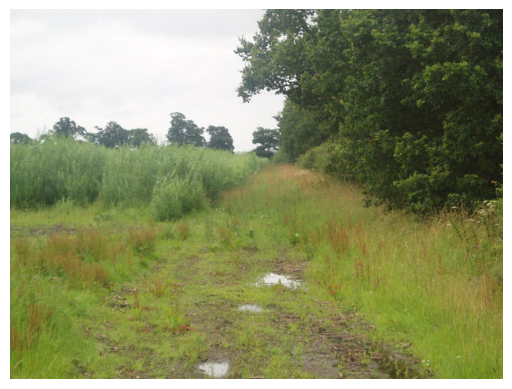

Processing images:  30%|███████▌                 | 3/10 [00:02<00:04,  1.44it/s]

resnet50 prediction on photos/50/05/500503_b90d0edc.jpg
0.139 -> pond
0.117 -> pasture
0.109 -> marsh
0.075 -> forest/broadleaf
0.058 -> field_road


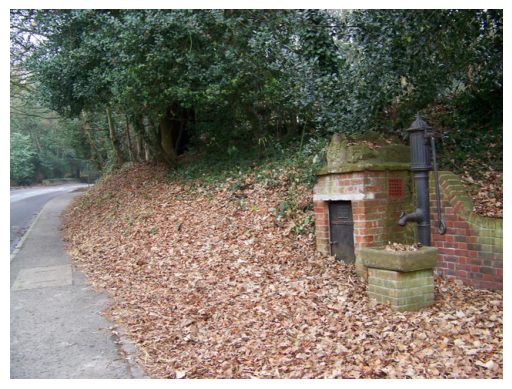

Processing images:  40%|██████████               | 4/10 [00:02<00:03,  1.57it/s]

resnet50 prediction on geophotos/01/10/48/1104897_b70532aa.jpg
0.089 -> childs_room
0.061 -> tundra
0.057 -> pond
0.042 -> nursery
0.033 -> sky


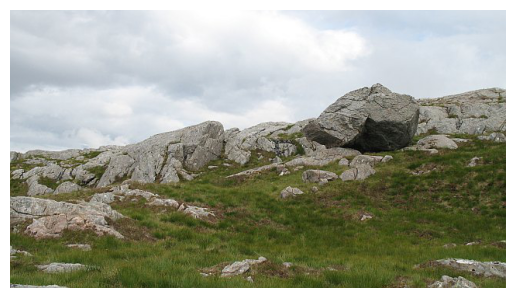

Processing images:  50%|████████████▌            | 5/10 [00:03<00:03,  1.54it/s]

resnet50 prediction on geophotos/01/14/81/1148139_b7ad8a21.jpg
0.291 -> wave
0.146 -> ice_shelf
0.109 -> ocean
0.097 -> mountain_snowy
0.088 -> ice_floe


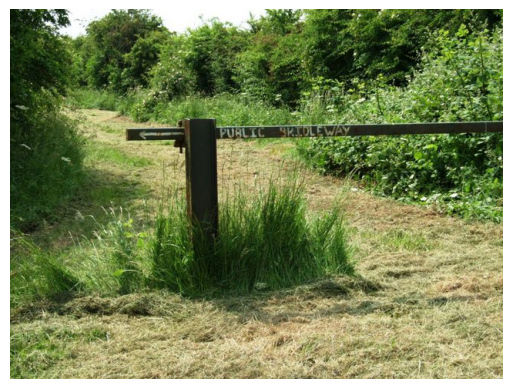

Processing images:  60%|███████████████          | 6/10 [00:04<00:02,  1.44it/s]

resnet50 prediction on photos/46/30/463087_2ce6cb48.jpg
0.184 -> marsh
0.152 -> lake/natural
0.106 -> pond
0.096 -> watering_hole
0.088 -> river


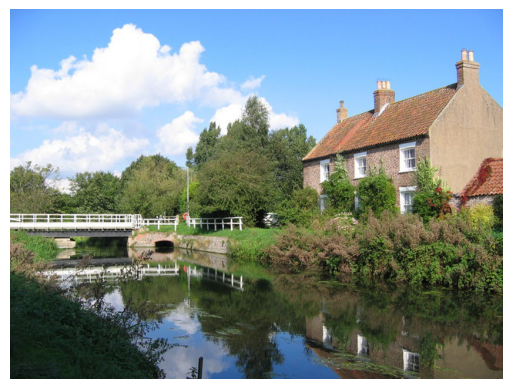

Processing images:  70%|█████████████████▌       | 7/10 [00:05<00:02,  1.40it/s]

resnet50 prediction on photos/25/23/252315_ef13b14a.jpg
0.112 -> boathouse
0.073 -> moat/water
0.067 -> marsh
0.064 -> lake/natural
0.054 -> pond


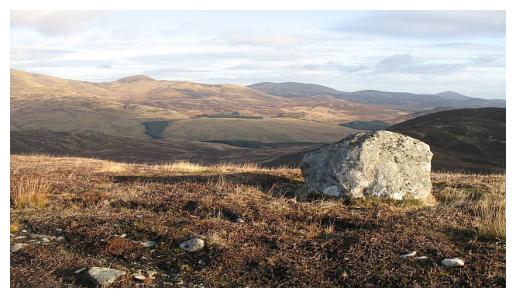

Processing images:  80%|████████████████████     | 8/10 [00:05<00:01,  1.38it/s]

resnet50 prediction on geophotos/01/05/07/1050780_586dc66f.jpg
0.283 -> tundra
0.189 -> desert/vegetation
0.141 -> field/cultivated
0.069 -> valley
0.035 -> field_road


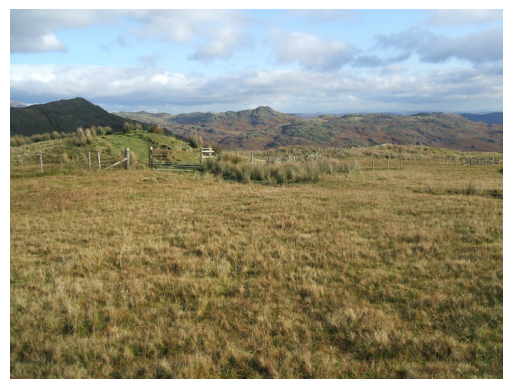

Processing images:  90%|██████████████████████▌  | 9/10 [00:06<00:00,  1.41it/s]

resnet50 prediction on geophotos/01/03/08/1030884_8abfc595.jpg
0.477 -> tundra
0.101 -> wind_farm
0.079 -> corn_field
0.070 -> wheat_field
0.038 -> valley


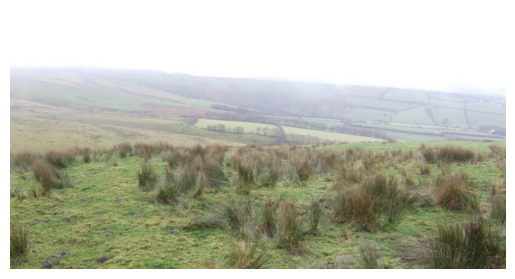

Processing images: 100%|████████████████████████| 10/10 [00:07<00:00,  1.41it/s]

resnet50 prediction on photos/62/19/621900_1fa54ae4.jpg
0.212 -> watering_hole
0.183 -> marsh
0.083 -> tundra
0.061 -> swamp
0.052 -> field/cultivated


In [28]:
data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

file_name = '/home/ubuntu/landscape-aesthetics/data/external/Places365/categories_places365.txt'
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)
file_location_path = Path.cwd()
project_base_path = file_location_path.parent.parent
scenic_or_not_paths = project_base_path / 'data' / 'external' / 'scenicornot'

img_data = pd.read_csv(os.path.join(scenic_or_not_paths, 'scenicornot.metadata.csv'), usecols = ['filename'])

sample_data = img_data.sample(n=10)
# sample_data = img_data.sample(n=10, random_state=5)

image_paths = sample_data.iloc[:, 0].tolist()

for img_path in tqdm(image_paths, desc="Processing images"):
    img = Image.open(os.path.join(scenic_or_not_paths, img_path) )
    input_img = V(data_transforms(img).unsqueeze(0))
    plt.imshow(img)
    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    plt.axis('off')
    plt.show()
    print('{} prediction on {}'.format(arch,img_path))
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))